In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

countries = CountryMetaDataFile().readMetadata()
dl = DataLib("SignalData")

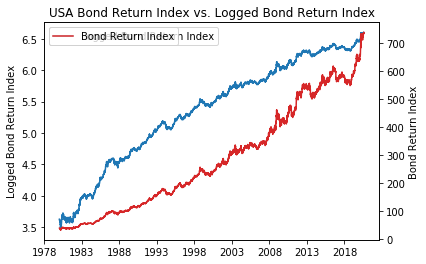

In [16]:
# Bond return setup
BondReturnIndex = dl.pull('BondRetIdx/LocalFX') # daily, represents accumulated returns from holding 10-year bonds
MonthlyBondReturnIndex = BondReturnIndex.resample('1M').mean()

average = 'Equal Weighted Mean'
BondReturnIndex[average] = BondReturnIndex.mean(axis=1)

country = 'USA'

# Visualizing Bond Return Index vs. Logged Bond Return Index
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Logged Bond Return Index'
ax1.plot(np.log(BondReturnIndex[country]).to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Return Index vs. Logged Bond Return Index')
plt.show()

# Indicator 1: Monetary Base

* What it is: accumulated M2 change over 3-month vs 12-month periods
* What it means: if the difference between the % change over the past 3-months and the % change over the past 12-months is positive, then the money supply is growing faster in the short term than the long term
* What it tells us: growth in the money supply can indicate expansionary monetary policy + higher propensity for increased inflation
* What this tells us about bonds: if we think inflation will increase/interest rates will rise, then we should short bonds (bonds will lose real value and bond prices will go down)

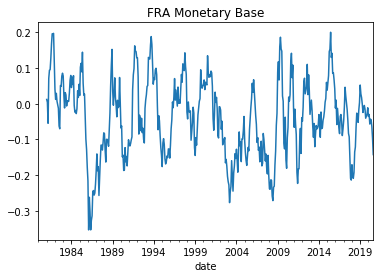

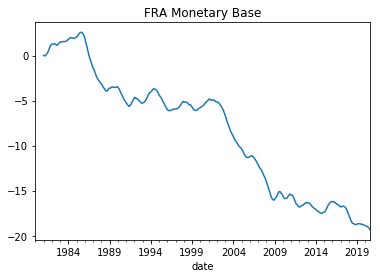

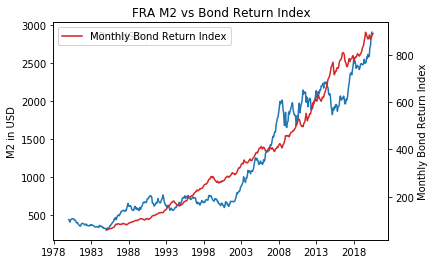

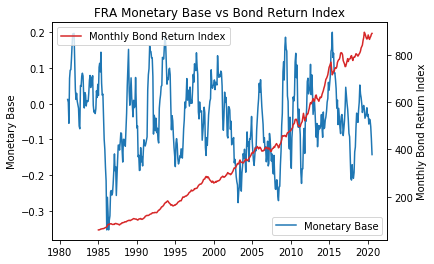

In [45]:
M2inUSD = dl.pull('M2/inUSD') # monthly

country = 'FRA'

# Monetary Base
MonetaryBase = M2inUSD.pct_change(3)-M2inUSD.pct_change(12)

## Am I interpreting Monetary Base correctly?

MonetaryBase[country].plot()
plt.title(f'{country} Monetary Base')
plt.show()

## I think that taking the cumsum() of this variable allows me to better interpret it
MonetaryBase[country].cumsum().plot()
plt.title(f'{country} Monetary Base')
plt.show()

## I may be having a misunderstanding about "change space"

# M2 vs. Bond Index Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'M2 in USD'
ax1.plot(M2inUSD[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Monthly Bond Return Index'
ax2.plot(MonthlyBondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} M2 vs Bond Return Index')
plt.show()

# Monetary Base vs. Bond Index Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Monetary Base'
ax1.plot(MonetaryBase[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Monthly Bond Return Index'
ax2.plot(MonthlyBondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Monetary Base vs Bond Return Index')
plt.show()

In [49]:
# Logically, if Monetary Base is increasing, then we should short bonds


## I am understanding indicator building correctly?

def MonetaryBase(country):
    MB = M2inUSD[country].pct_change(3)-M2inUSD[country].pct_change(12)
    MB_Upsampled = MB.resample('1D').ffill()
    prediction = []
    
    for i in MB_Upsampled:
        if i > 0: # M2 growing, short bonds
            
            # here is where I could scale my position based on country-specific or global averages
            prediction.append(0)
        else: 
            prediction.append(1)
            
    #MB['Prediction'] = prediction
    
    return MB


print(MonetaryBase('FRA'))



date
1980-01         NaN
1980-02         NaN
1980-03         NaN
1980-04         NaN
1980-05         NaN
1980-06         NaN
1980-07         NaN
1980-08         NaN
1980-09         NaN
1980-10         NaN
1980-11         NaN
1980-12         NaN
1981-01    0.011728
1981-02    0.003887
1981-03   -0.054788
1981-04    0.070743
1981-05    0.093399
1981-06    0.094979
1981-07    0.126240
1981-08    0.166460
1981-09    0.195088
1981-10    0.195105
1981-11    0.196364
1981-12    0.117453
1982-01    0.040293
1982-02    0.011913
1982-03    0.028921
1982-04    0.006655
1982-05   -0.003426
1982-06   -0.012801
             ...   
2018-03   -0.208567
2018-04   -0.192257
2018-05   -0.134866
2018-06   -0.121104
2018-07   -0.066591
2018-08   -0.026445
2018-09   -0.032808
2018-10   -0.052210
2018-11   -0.017379
2018-12    0.003233
2019-01    0.052005
2019-02    0.027081
2019-03    0.017105
2019-04   -0.000371
2019-05   -0.024672
2019-06   -0.013329
2019-07   -0.004992
2019-08   -0.014877
2019-09   -0.04

In [ ]:
# P&L 

